In [4]:
# %matplotlib widget
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
import scipy as sp
import json
import cProfile
import re 
from timeit import default_timer as timer

from scipy.fft import fft, fftfreq
from slab.instruments.instrumentmanager import InstrumentManager
#from slab.instruments.instrumenttypes import Instrument
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
from datetime import datetime
import experiments as meas
import autocalib_config as cfg
import yaml
import config
from datetime import date

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
print('done')

import importlib 
importlib.reload(meas)
cfg_path='c:\\_Lib\\python\\slab_rfsoc_expts\\'
tuning_path='C:\\_Data\\LLqub2\\Tuning_2024_05_12\\'
print('done')

# Results config file:
print('done')

cfg_file = 'coherence2405_play.yml'
cfg_path = cfg_path + cfg_file
cfg_file = cfg_path 
auto_cfg = config.load(cfg_path)
print('done')

# Connect to instruments 
im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
print('done')

soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
print(soc)
print(auto_cfg['aliases']['soc'])
print(soc.description())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done
imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.crud
imported experiments.single_qubit.DONOTUSE_ramsey_ef
imported experiments.single_qubit.DONOTUSE_randbench
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy_test
imported experiments.single_qubit.rb_ziqian
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.SingleRB
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experim

In [5]:
def in_rng(val, rng):
    if val<rng[0]:
        val=rng[0]
    elif val>rng[1]:
        val=rng[1]
    return val

### Init point + single evo point T1 continuous with Calib

C:\_Data\Coherence\T1_cont_2024-07-11-20-27-55\
<Pyro4.core.Proxy at 0x1be73998bb0; connected IPv4; for PYRO:obj_c04bf73ecb1d4eb2b59ad71361cbb6f8@192.168.137.233:35387>


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Saving C:\_Data\Coherence\T1_cont_2024-07-11-20-27-55\00000_single_shot_qubit0.h5
Unrotated:
Ig -1.1570964247020585 +/- 0.4690863279749015 	 Qg -0.023835319609967497 +/- 0.4676919360613891 	 Amp g 1.157341893529823
Ie 0.180931744312026 +/- 0.5797714188910423 	 Qe 0.1657638136511376 +/- 0.4699750721865258 	 Amp e 0.2453852848399052
hi
Rotated:
Ig -1.1489763394300052 +/- 0.4690863279749015 	 Qg 0.1385660388448574 +/- 0.4676919360613891 	 Amp g 1.1573016787731405
Ie 0.20051816521989316 +/- 0.5797714188910423 	 Qe 0.14465484930246694 +/- 0.4699750721865258 	 Amp e 0.24724999496435138


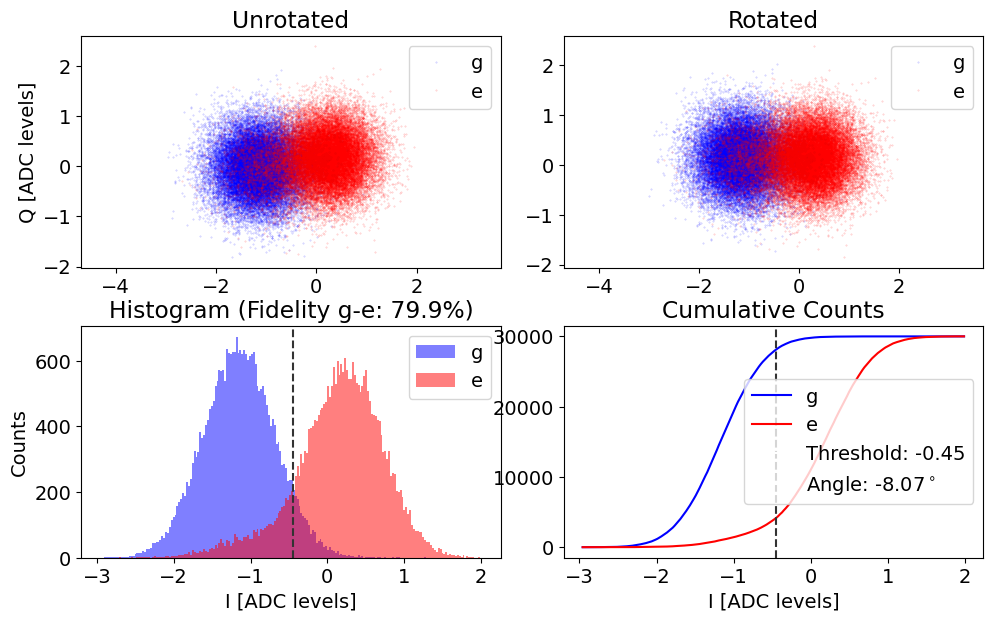

ge fidelity (%): 79.9259975332511
rotation angle (deg): -8.06514118072924
threshold ge: -0.44939562176282033
*Set cfg resonator 0 phase to -8.06514118072924 from -6.145204175053389*
*Set cfg resonator 0 threshold to -0.44939562176282033 from -0.4958157566334318*
gauss


  0%|          | 0/4000 [00:00<?, ?it/s]

Saving C:\_Data\Coherence\T1_cont_2024-07-11-20-27-55\00000_amp_rabi_qubit0.h5
Pi gain from amps data [dac units]: 8667
	Pi/2 gain from amps data [dac units]: 4333
Pi gain from avgi data [dac units]: 8778
	Pi/2 gain from avgi data [dac units]: 4389
Pi gain from avgq data [dac units]: 5140
	Pi/2 gain from avgq data [dac units]: 2570


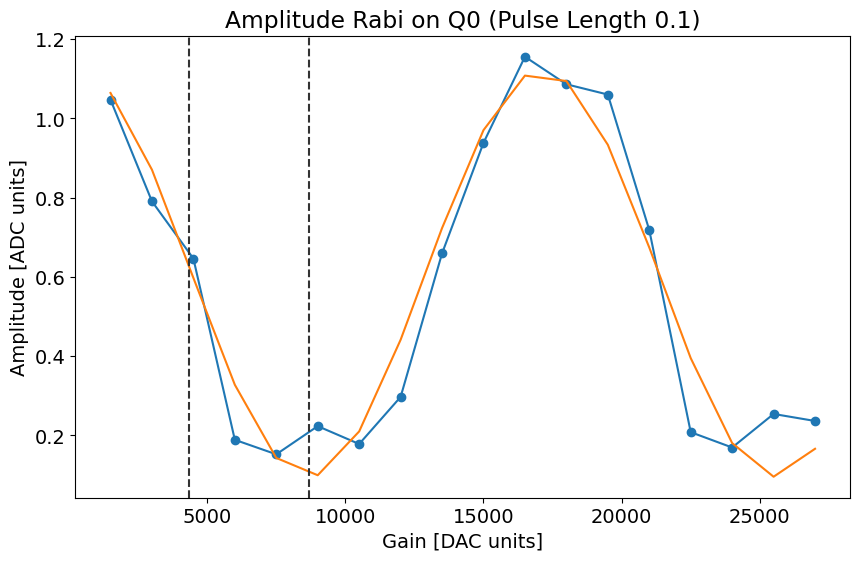

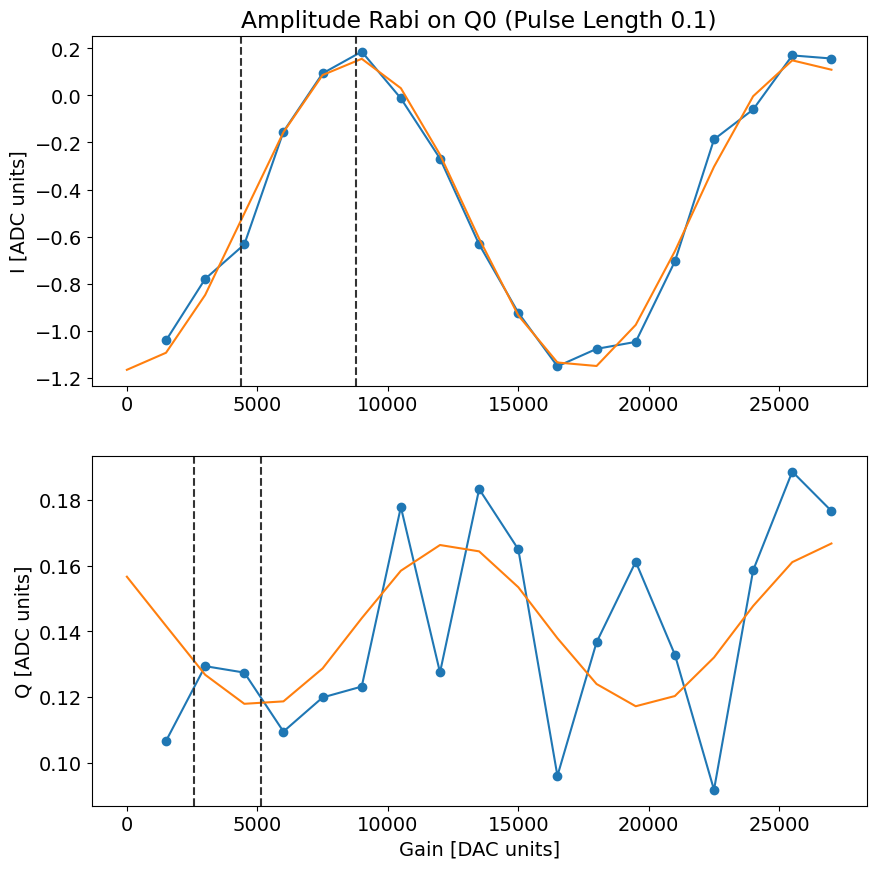

  0%|          | 0/2 [00:00<?, ?it/s]

Saving C:\_Data\Coherence\T1_cont_2024-07-11-20-27-55\00000_ramsey_qubit0.h5


ValueError: too many values to unpack (expected 3)

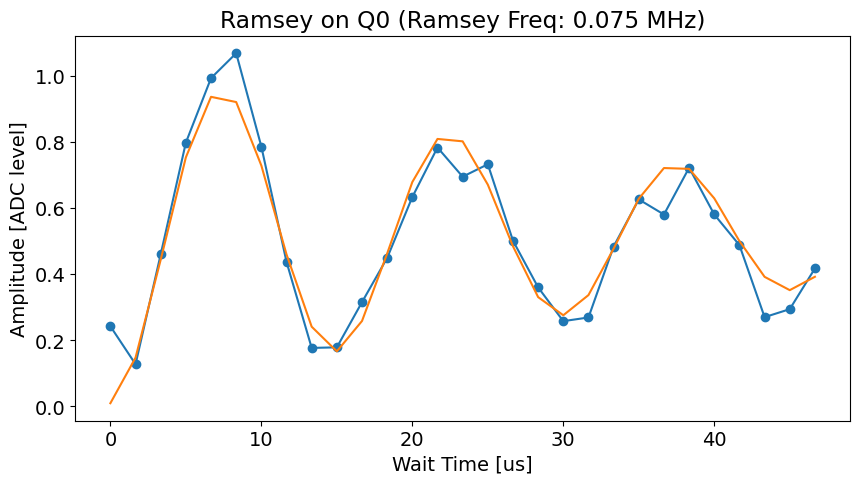

In [7]:
now = datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M-%S")
pth='C:\\_Data\\Coherence\\'
folder_name = f"T1_cont_{current_time}"
os.mkdir(pth + folder_name)
expt_path = pth + folder_name + '\\'
print(expt_path)
t1_rng = [5,100]
t2_rng = [5,200]
#t2_1 = 200
new_t1 = 25
t2_1 = 50
nreps_t1 = 400
npts_t1 = 30
i=0
chan = 'fit_avgi'
chant1='fit_avgi'
while True:
    shot = cfg.make_singleshot(soc, expt_path, cfg_path, i, go=True, im=im, reps=30000)
   
    config.update_readout(cfg_file, 'phase', float(shot.data['angle']), i)
    config.update_readout(cfg_file, 'threshold', float(shot.data['thresholds'][0]), i)
    
    amp_rabi = cfg.make_amprabi(soc, expt_path, cfg_path, i, go=True, im=im, npts=20, reps=200)    
    #t2r=cfg.make_t2r(soc, expt_path, cfg_path, i, go=True, im=im, ramsey_freq=0.025, npts=40, reps=250, step=3.5)
    npts = 30
    t2r=cfg.make_t2r(soc, expt_path, cfg_path, i, go=True, im=im, ramsey_freq=npts/t2_1/8, npts=npts, reps=250, step=t2_1/npts)
    t2_1 = in_rng(t2r.data[chan][3], t2_rng)

    npts=30
    t1 = cfg.make_t1(soc, expt_path, cfg_path, i, go=True, im=im, npts=npts_t1, reps=nreps_t1, span=3.5*new_t1)
    t1_1 = t1.data[chant1][3]

    t1 = cfg.make_t1(soc, expt_path, cfg_path, i, go=True, im=im, npts=npts_t1, reps=nreps_t1, span=3.5*t1_1)
    t1_2 = t1.data[chant1][3]

    t1 = cfg.make_t1(soc, expt_path, cfg_path, i, go=True, im=im, npts=npts_t1, reps=nreps_t1, span=3.5*t1_1)
    t1_3 = t1.data[chant1][3]
    

    new_t1 =  1/2*(t1_2+t1_3)
    new_t1 = in_rng(new_t1, t1_rng)
    print(new_t1)
    #t1_cont = cfg.make_t1_cont(soc, expt_path, cfg_path, i)
    t1 = cfg.make_t1doub(soc, expt_path, cfg_path, i, reps=40000000, go=True, delay_time=new_t1) 


    # t1_cont.cfg.expt.start = new_t1
    # t1_cont.go(analyze=False, display=False, progress=True, save=True)

### Short T1 scans

<Pyro4.core.Proxy at 0x1d9bb1a77c0; connected IPv4; for PYRO:obj_f90cbadf8de648e59b61c0011eba9d33@192.168.137.233:35515>


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\T1_short_2024-05-15-07-05-25\00000_single_shot_qubit3.h5
Unrotated:
Ig 1.9834568794069787 +/- 3.7177571177633295 	 Qg 2.485807268125113 +/- 3.6492083175172905 	 Amp g 3.1801476328514227
Ie 14.481558488519255 +/- 5.213481269838505 	 Qe 2.171035979027301 +/- 3.6749556849396128 	 Amp e 14.643392143852296
hi
Rotated:
Ig 1.915219696954987 +/- 3.7177571177633295 	 Qg 2.5392293136681765 +/- 3.6492083175172905 	 Amp g 3.1805269995703713
Ie 14.41855748167978 +/- 5.213481269838505 	 Qe 2.519746347353529 +/- 3.6749556849396128 	 Amp e 14.637073529483462


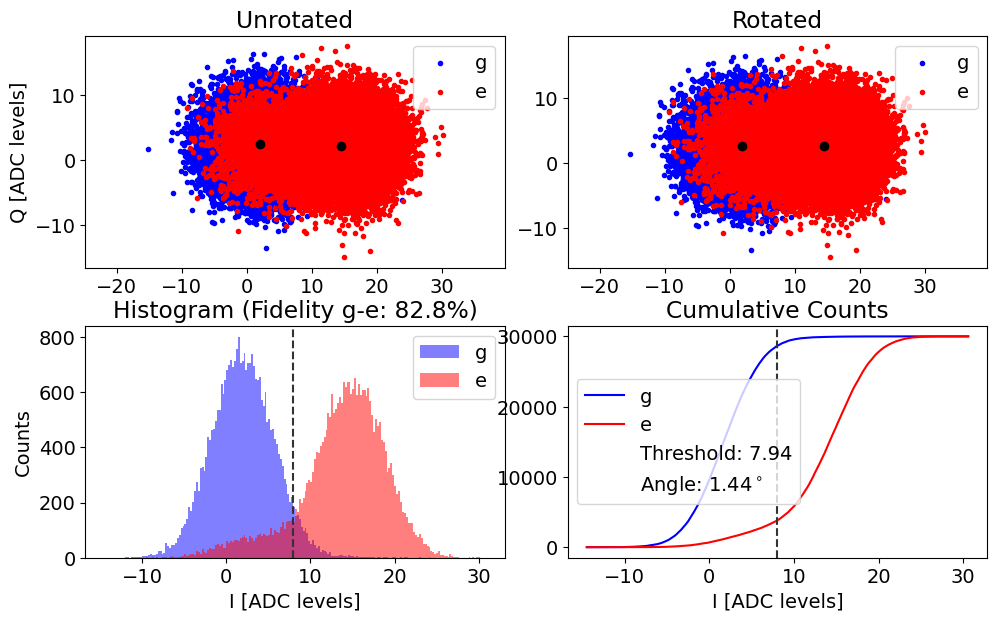

ge fidelity (%): 82.80804680078
rotation angle (deg): 1.4427194715234586
threshold ge: 7.9405503231540955
*Set cfg resonator 3 phase to 1.4427194715234586 from 1.0793280987607274*
*Set cfg resonator 3 threshold to 7.9405503231540955 from 8.0234354276591*
gauss


  0%|          | 0/4000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\T1_short_2024-05-15-07-05-25\00000_amp_rabi_qubit3.h5
Pi gain from amps data [dac units]: 15214
	Pi/2 gain from amps data [dac units]: 7607
Pi gain from avgi data [dac units]: 15232
	Pi/2 gain from avgi data [dac units]: 7616
Pi gain from avgq data [dac units]: 46680
	Pi/2 gain from avgq data [dac units]: 23340


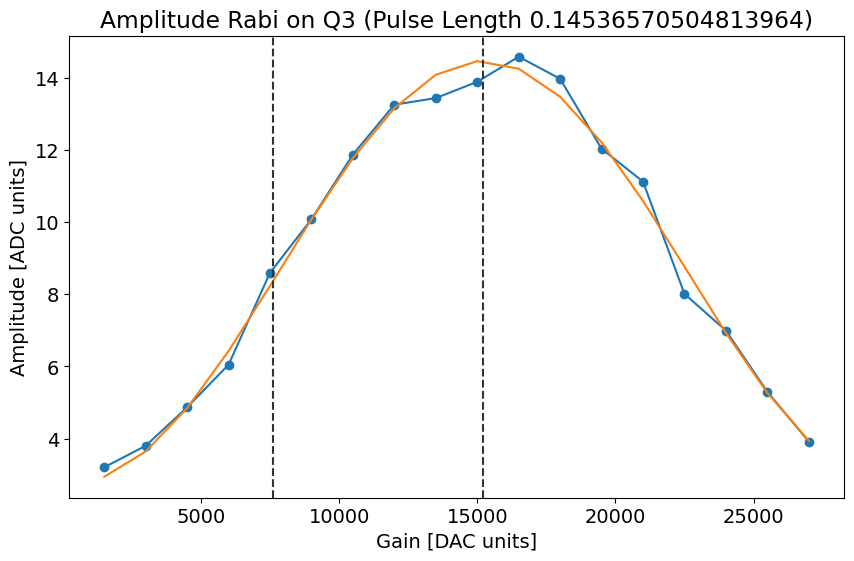

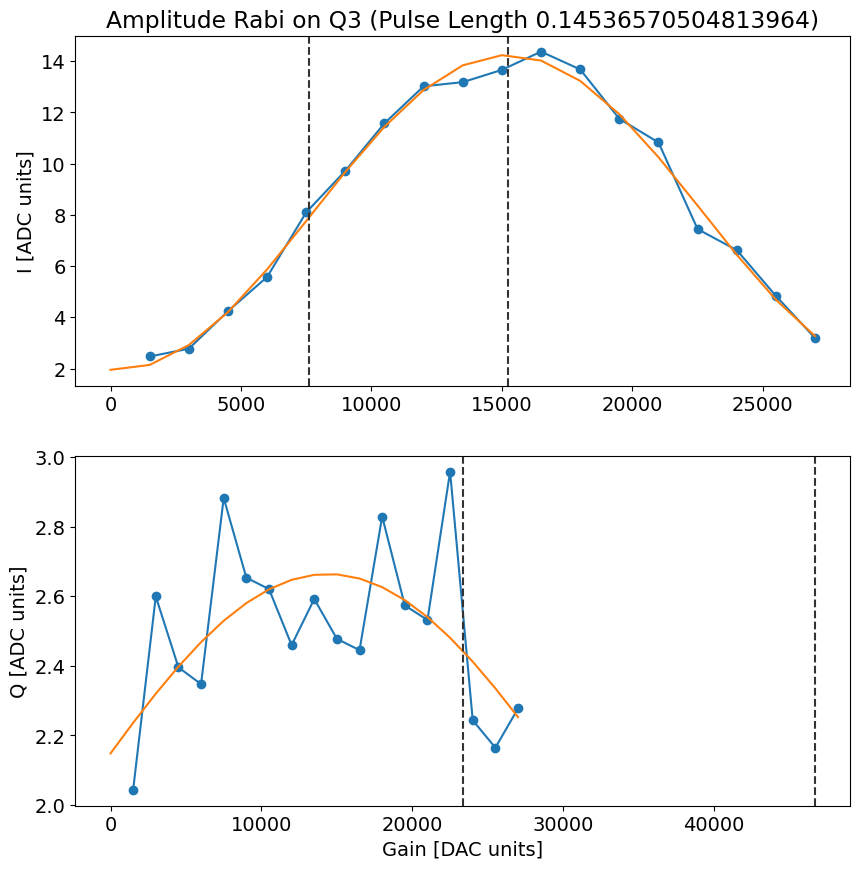

*Set cfg qubit 3 ('pulses', 'pi_ge', 'gain') to 15232 from 15334*


  0%|          | 0/2 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\T1_short_2024-05-15-07-05-25\00000_ramsey_qubit3.h5
Current pi pulse frequency: 3548.809519535817
Fit frequency from amps [MHz]: 0.01918448943699966 +/- 7.057765987714892e-05
T2 Ramsey from fit amps [us]: 237.3019837677655
Current pi pulse frequency: 3548.809519535817
Fit frequency from I [MHz]: 0.019188562152255177 +/- 7.434747723128169e-05
T2 Ramsey from fit I [us]: 232.44741268976455
Fit frequency from Q [MHz]: 0.06680594658029113 +/- 0.0010171506910280556
T2 Ramsey from fit Q [us]: 91.20613911632657
Suggested new pi pulse frequency from fit 3548.8091:



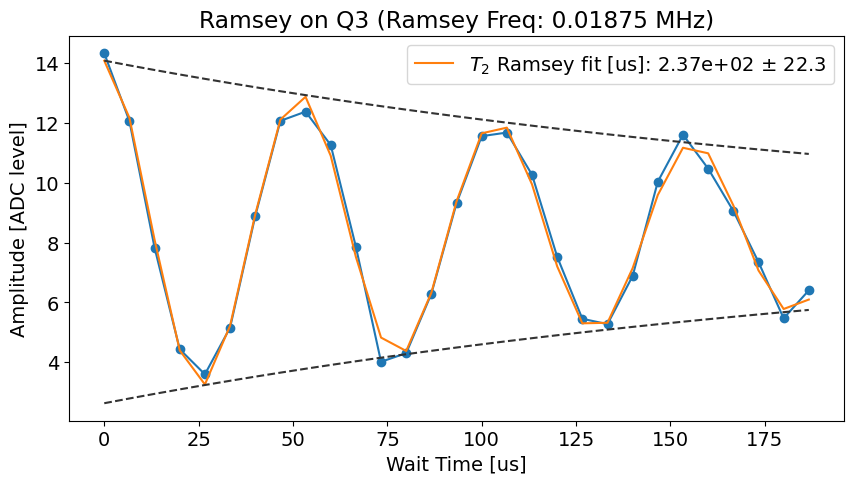

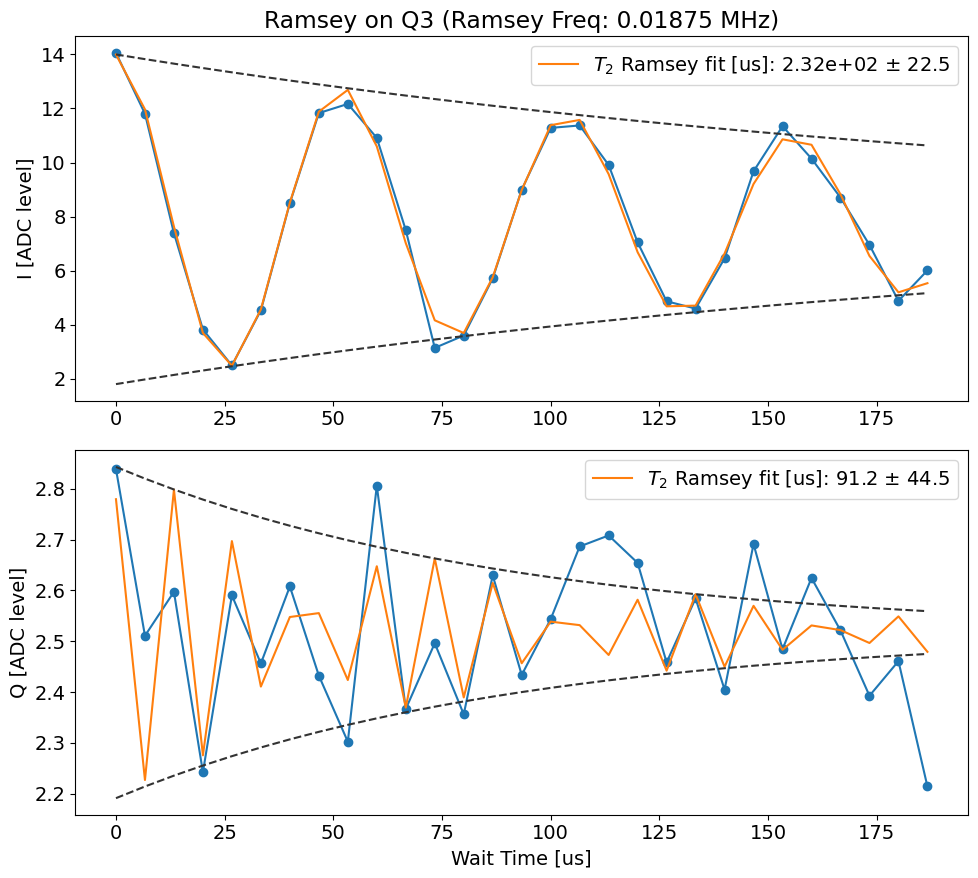

*Set cfg qubit 3 f_ge to 3548.80908504638 from 3548.809519535817*


  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\slab\anaconda3\envs\slab\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


t1_i error:fit ratio= 0.19164410596796586
t1_q error:fit ratio= -inf
t1_q is better, saving t1_q to results cfg file
Saving C:\_Data\LLqub2\T1_short_2024-05-15-07-05-25\00000_t1_qubit3.h5
Fit T1 avgi [us]: 204.03629516151491
Fit T1 avgq [us]: -282.542258826463


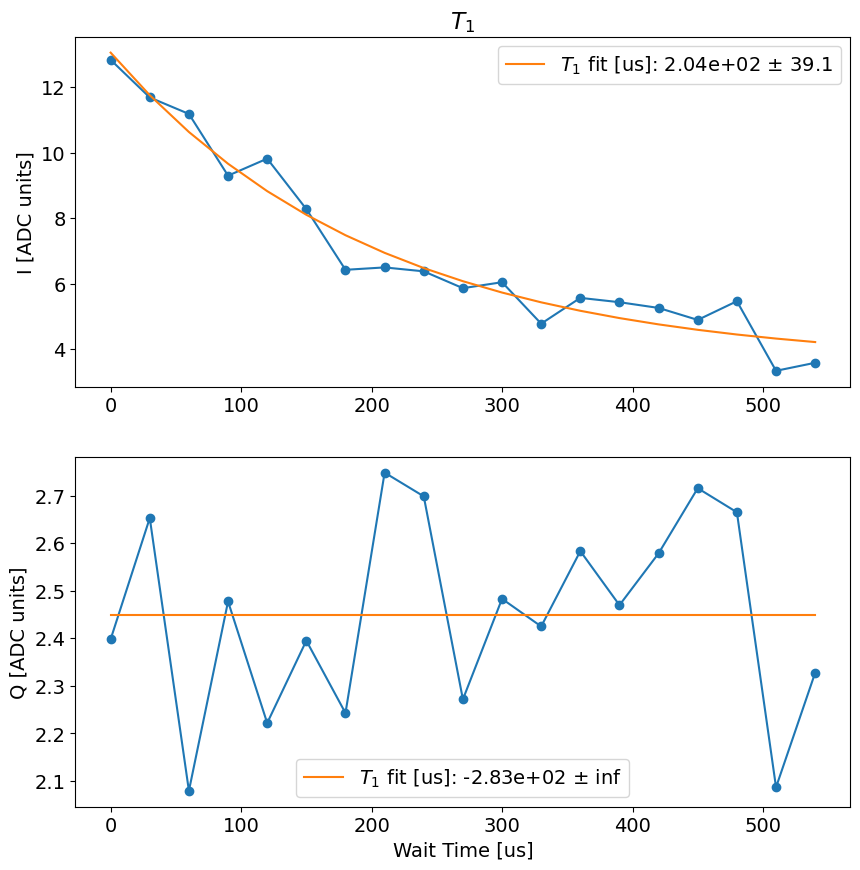

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00002_t1_2d_qubit3.h5


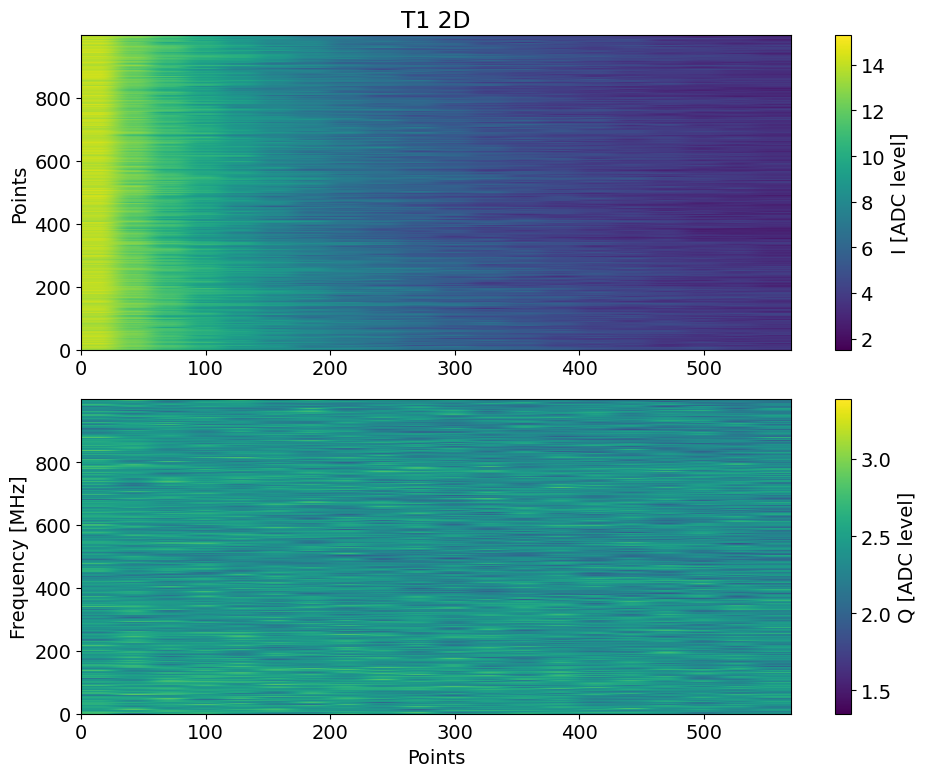

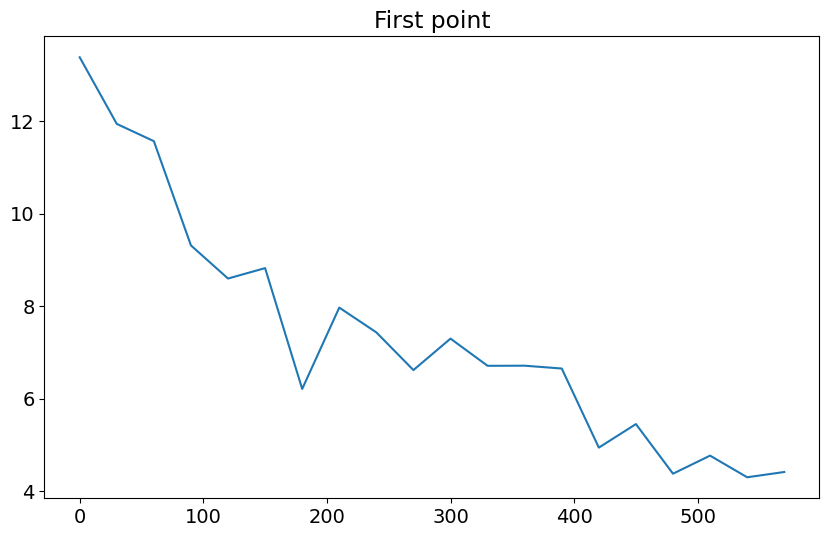

  0%|          | 0/5000 [00:00<?, ?it/s]

t1_i error:fit ratio= 0.19245078801679566
t1_q error:fit ratio= inf
t1_i is better, saving T1_i to results cfg file
Saving C:\_Data\LLqub2\T1_short_2024-05-15-07-05-25\00001_t1_qubit3.h5
Fit T1 avgi [us]: 164.21447924736
Fit T1 avgq [us]: 444.0788895601729


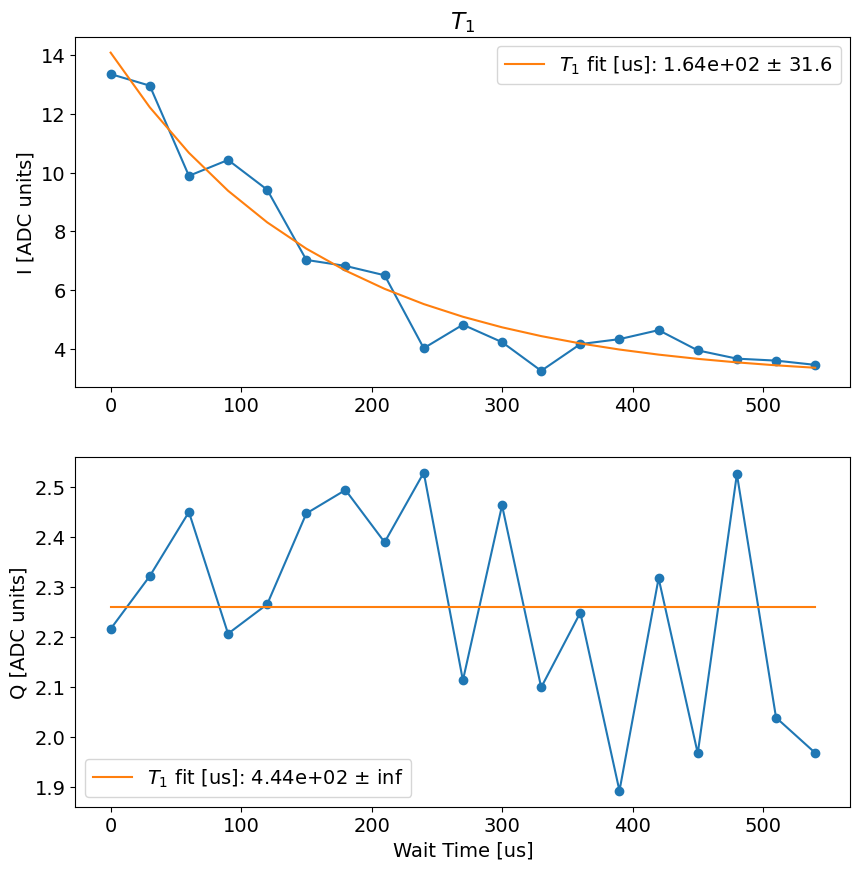

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00003_t1_2d_qubit3.h5


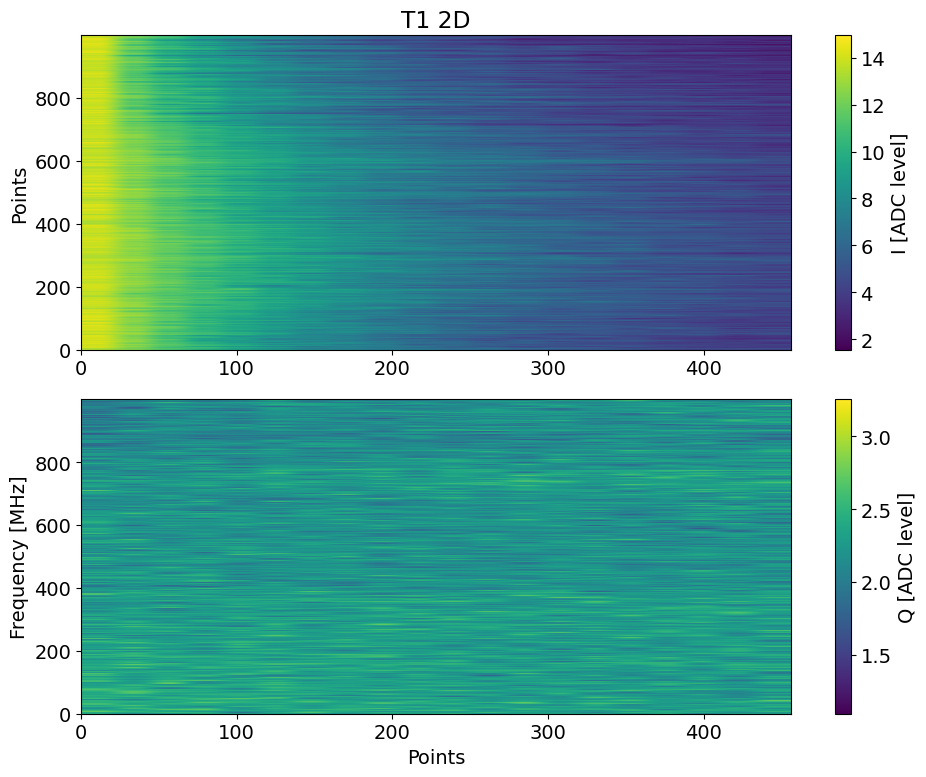

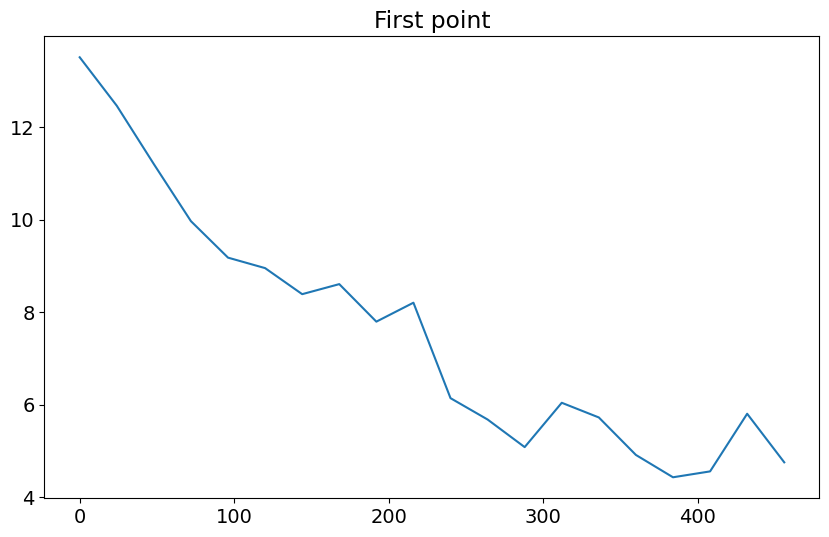

  0%|          | 0/5000 [00:00<?, ?it/s]

t1_i error:fit ratio= 0.15948606739015275
t1_q error:fit ratio= -inf
t1_q is better, saving t1_q to results cfg file
Saving C:\_Data\LLqub2\T1_short_2024-05-15-07-05-25\00002_t1_qubit3.h5
Fit T1 avgi [us]: 130.1714809848086
Fit T1 avgq [us]: -70.93118820321405


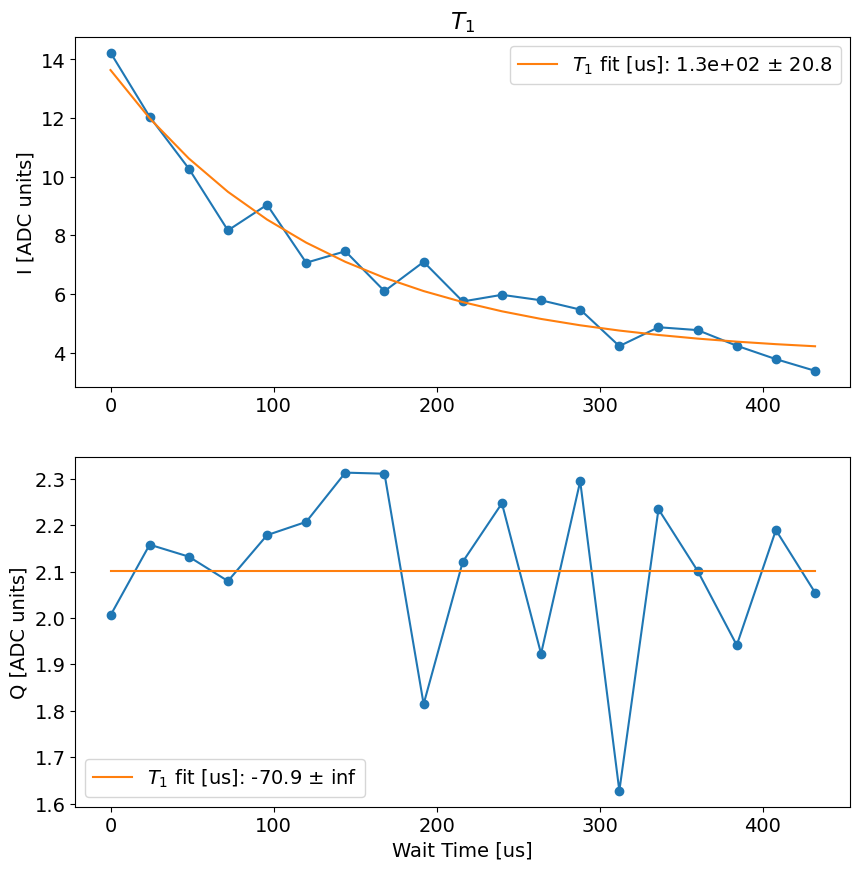

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00004_t1_2d_qubit3.h5


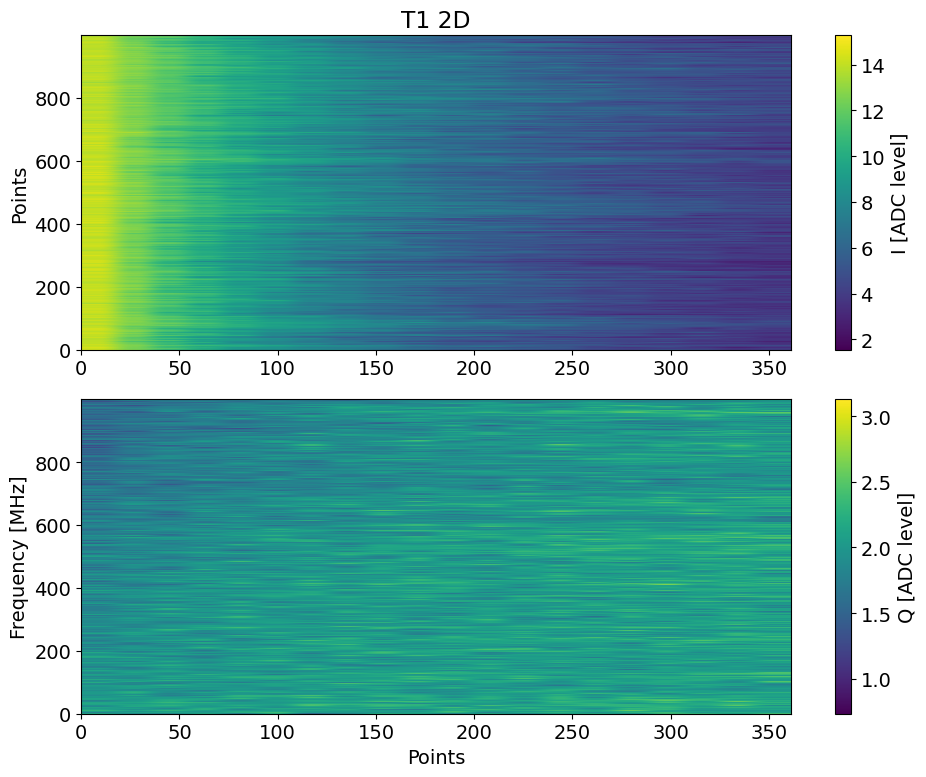

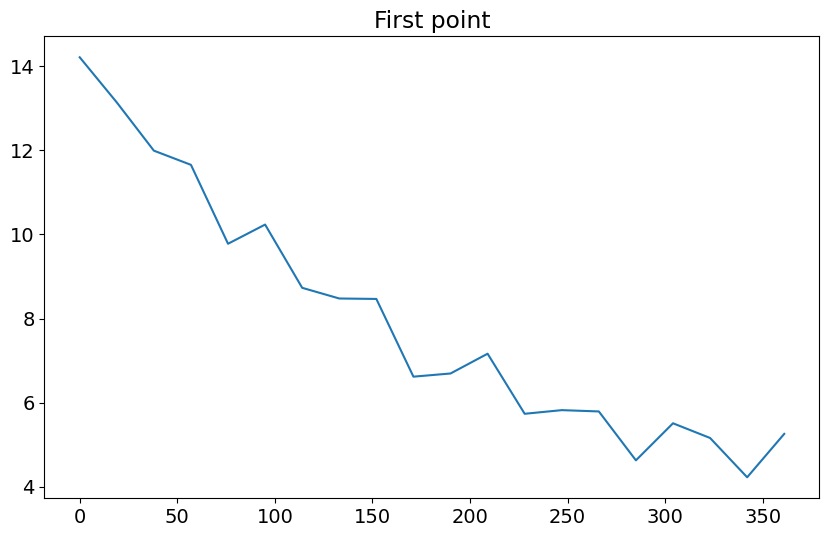

  0%|          | 0/5000 [00:00<?, ?it/s]

t1_i error:fit ratio= 0.38779542779162185
t1_q error:fit ratio= -0.8418232410350266
t1_q is better, saving t1_q to results cfg file
Saving C:\_Data\LLqub2\T1_short_2024-05-15-07-05-25\00003_t1_qubit3.h5
Fit T1 avgi [us]: 284.11477422875214
Fit T1 avgq [us]: -104.18201149910328


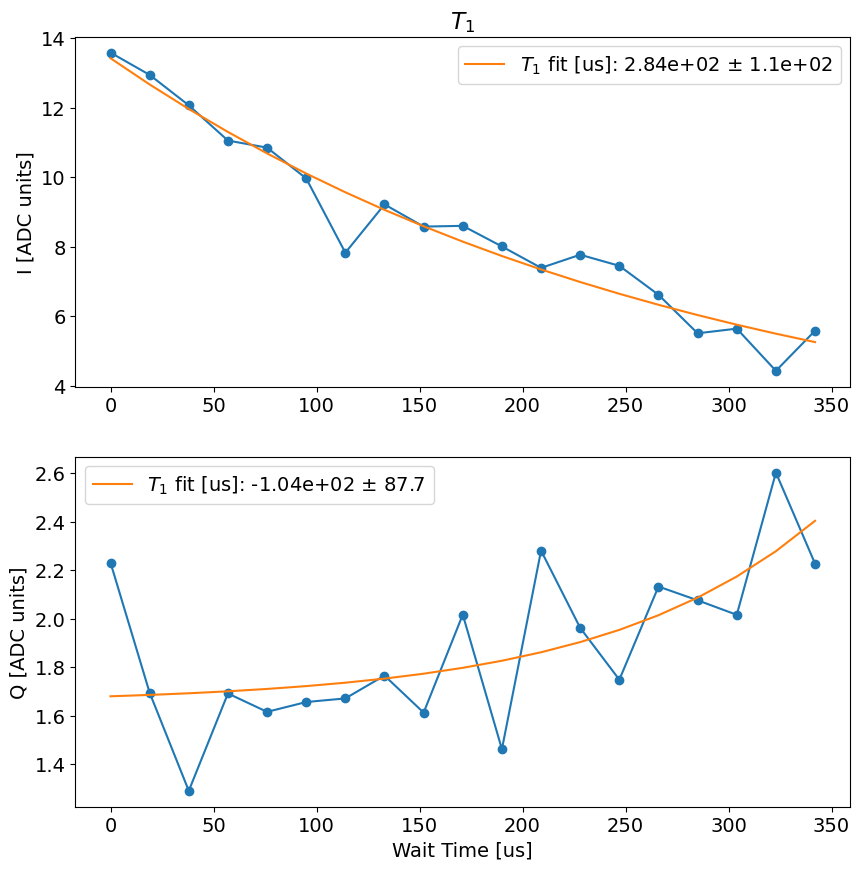

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00005_t1_2d_qubit3.h5


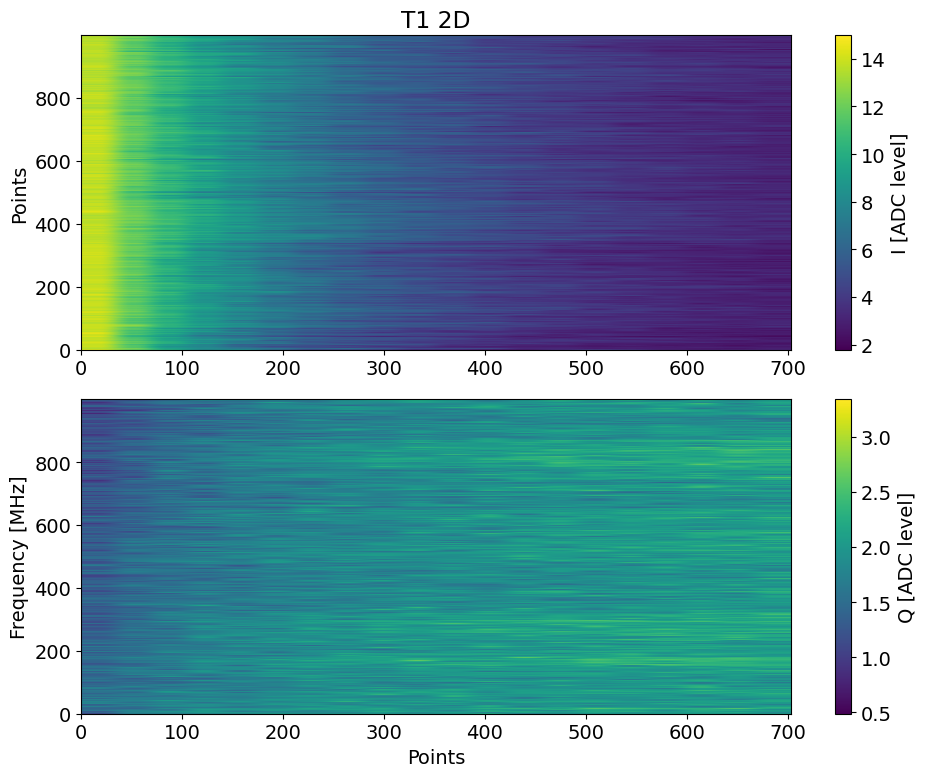

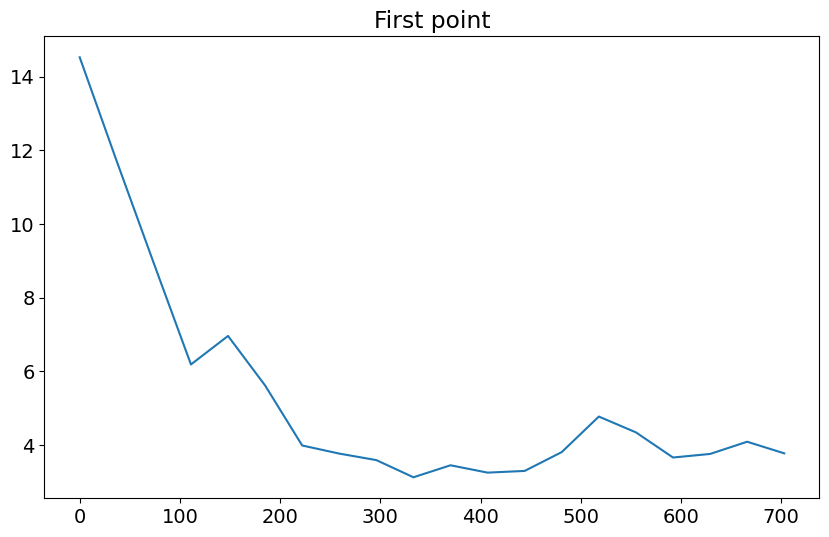

  0%|          | 0/5000 [00:00<?, ?it/s]

t1_i error:fit ratio= 0.2562310438986236
t1_q error:fit ratio= 8.986997918125347
t1_i is better, saving T1_i to results cfg file
Saving C:\_Data\LLqub2\T1_short_2024-05-15-07-05-25\00004_t1_qubit3.h5
Fit T1 avgi [us]: 211.6265226403999
Fit T1 avgq [us]: 5575.025033358509


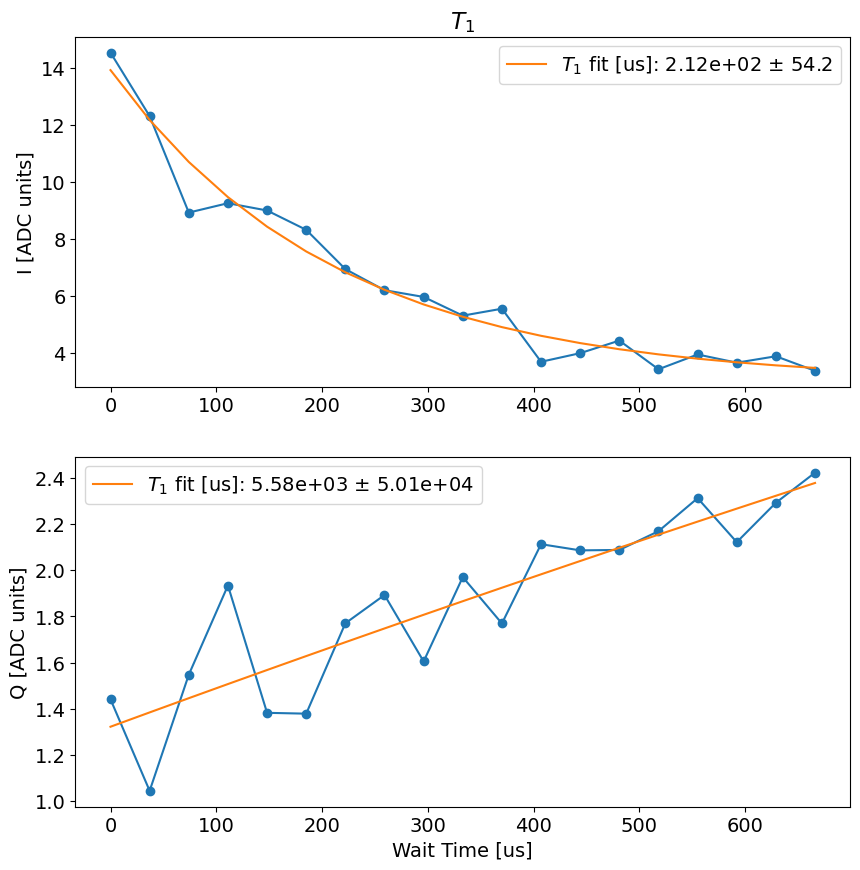

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00006_t1_2d_qubit3.h5


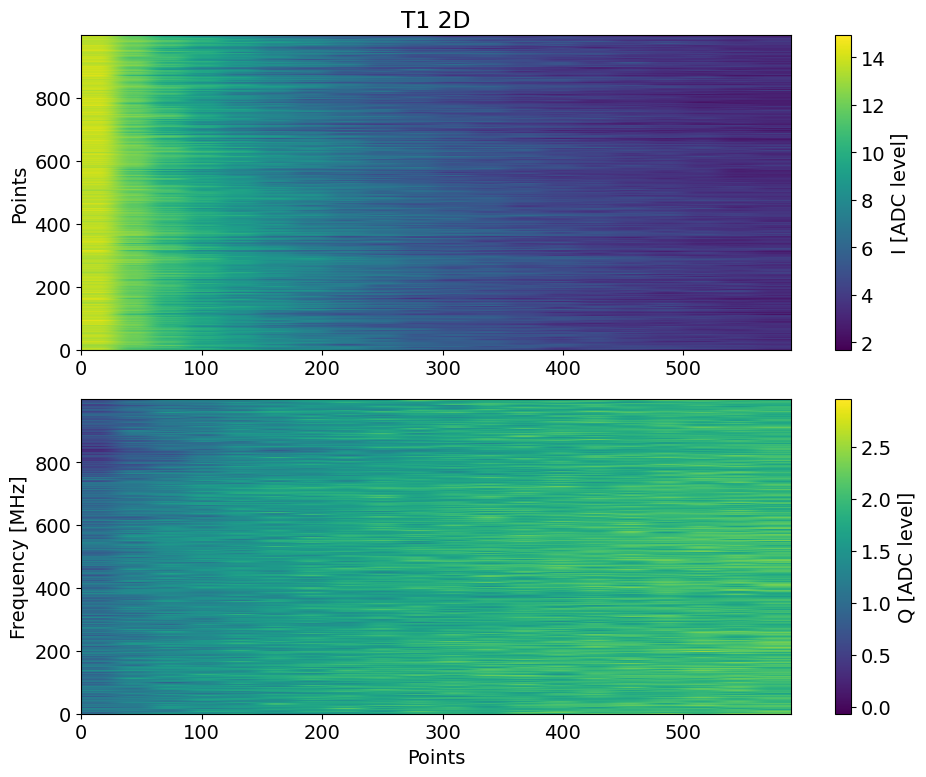

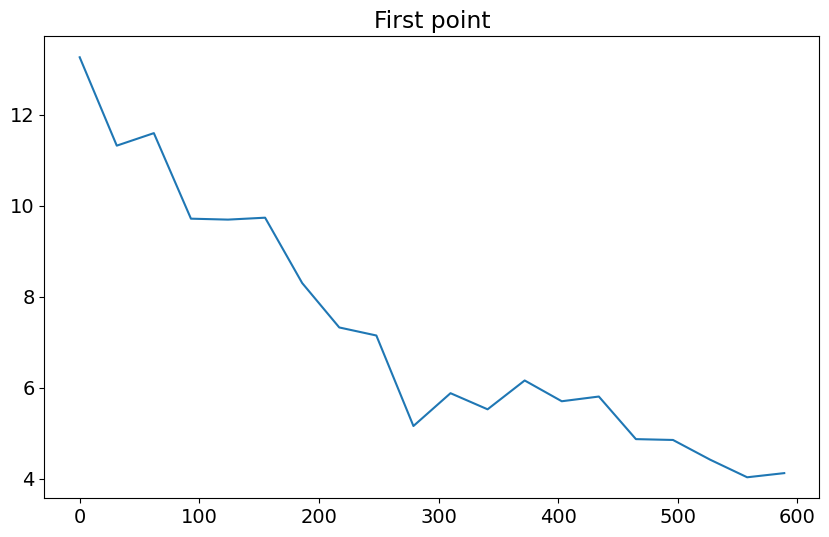

  0%|          | 0/5000 [00:00<?, ?it/s]

t1_i error:fit ratio= 0.1506415572450791
t1_q error:fit ratio= 0.26574300487425034
t1_i is better, saving T1_i to results cfg file
Saving C:\_Data\LLqub2\T1_short_2024-05-15-07-05-25\00005_t1_qubit3.h5
Fit T1 avgi [us]: 139.3214415880261
Fit T1 avgq [us]: 104.98971059762822


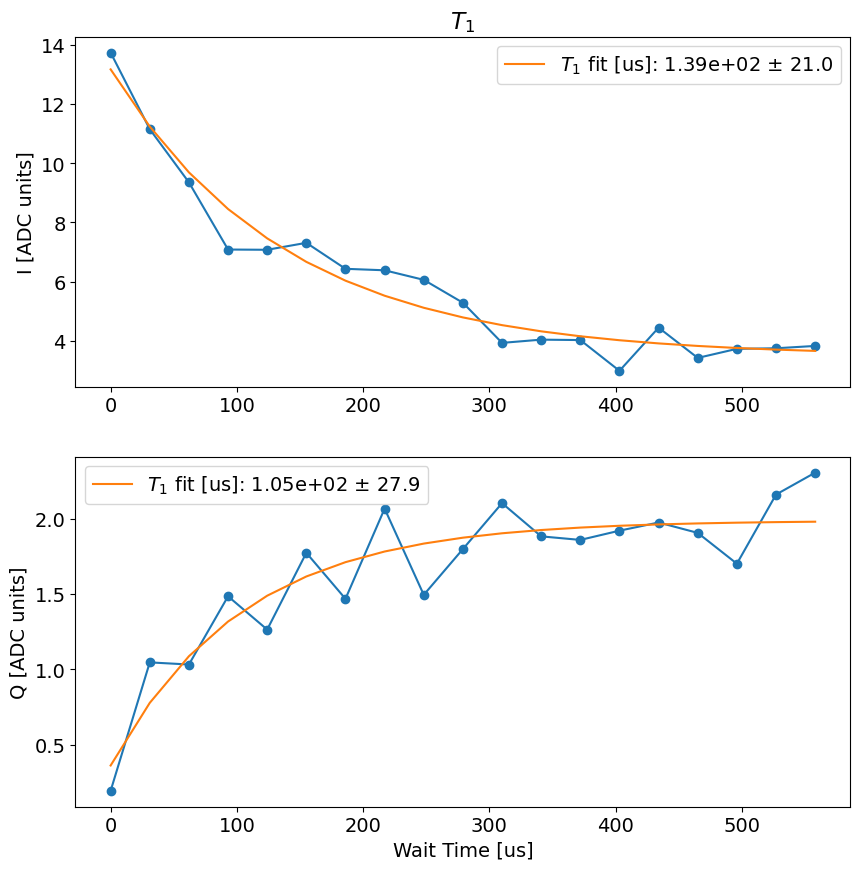

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00007_t1_2d_qubit3.h5


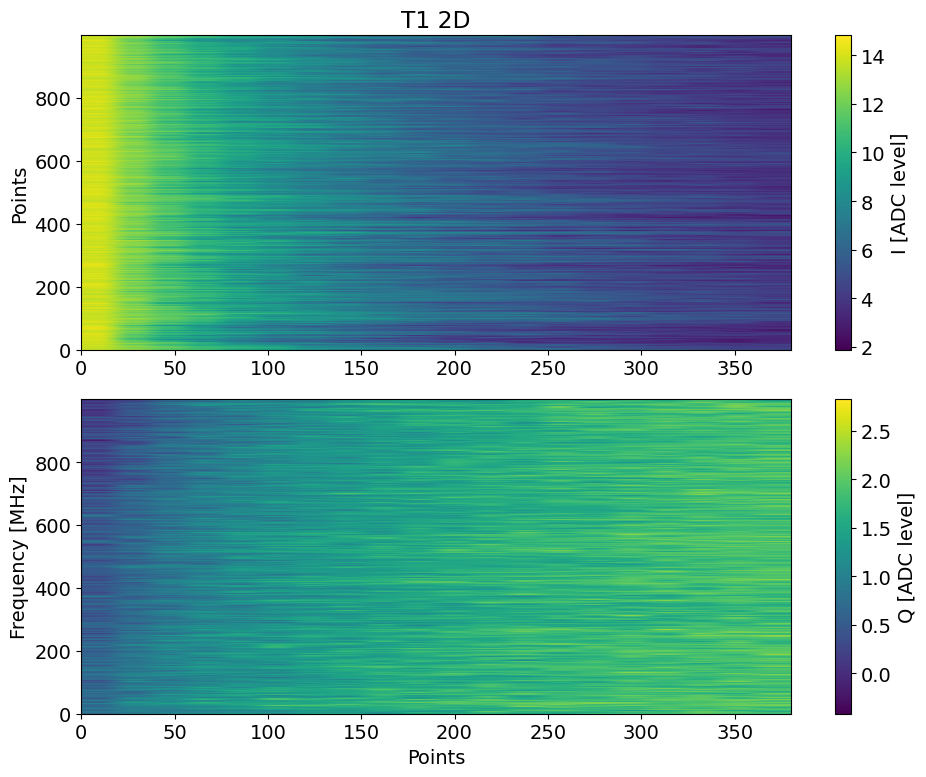

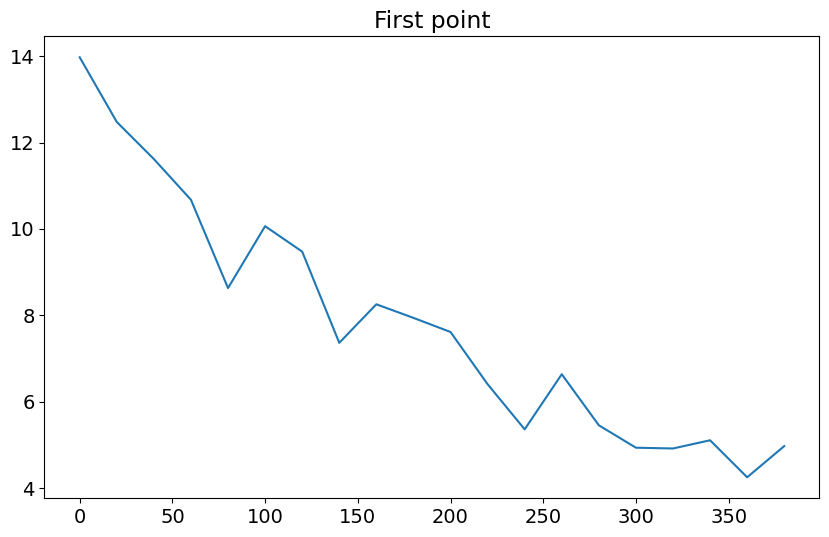

  0%|          | 0/5000 [00:00<?, ?it/s]

t1_i error:fit ratio= 0.40564856140064953
t1_q error:fit ratio= 0.2779877935596552
t1_q is better, saving t1_q to results cfg file
Saving C:\_Data\LLqub2\T1_short_2024-05-15-07-05-25\00006_t1_qubit3.h5
Fit T1 avgi [us]: 251.0770199988124
Fit T1 avgq [us]: 106.52538238992352


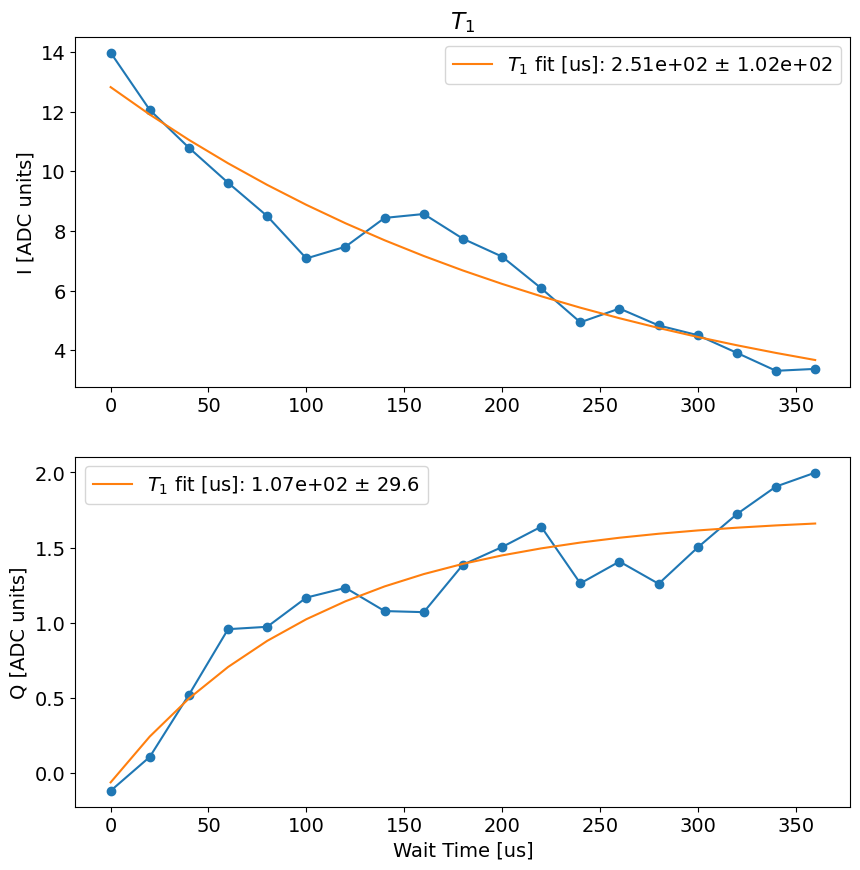

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00008_t1_2d_qubit3.h5


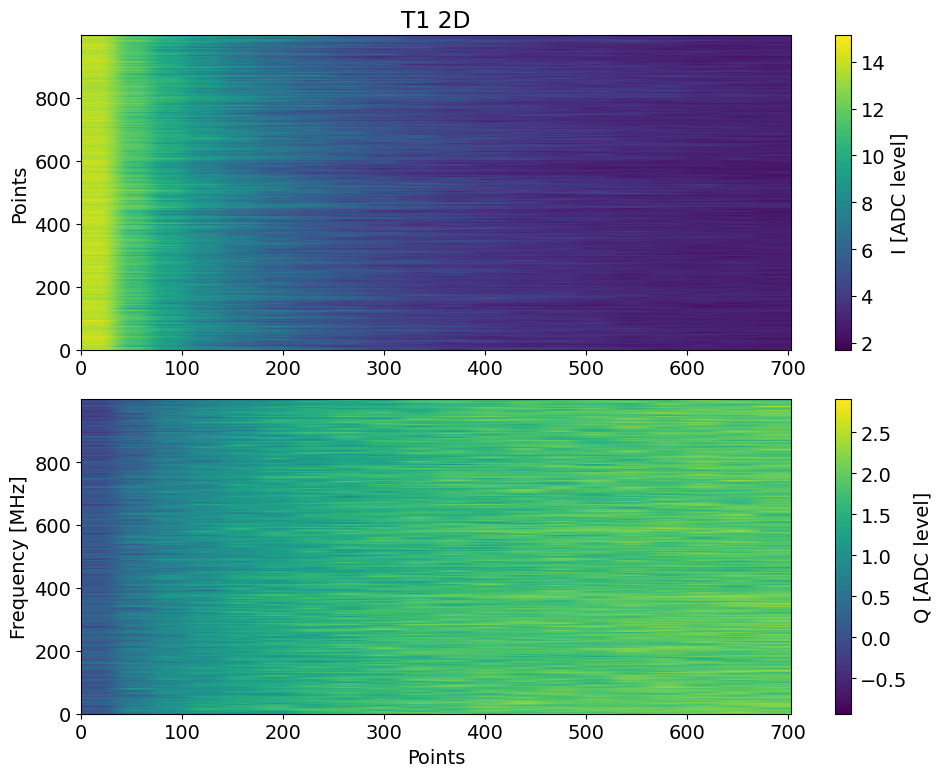

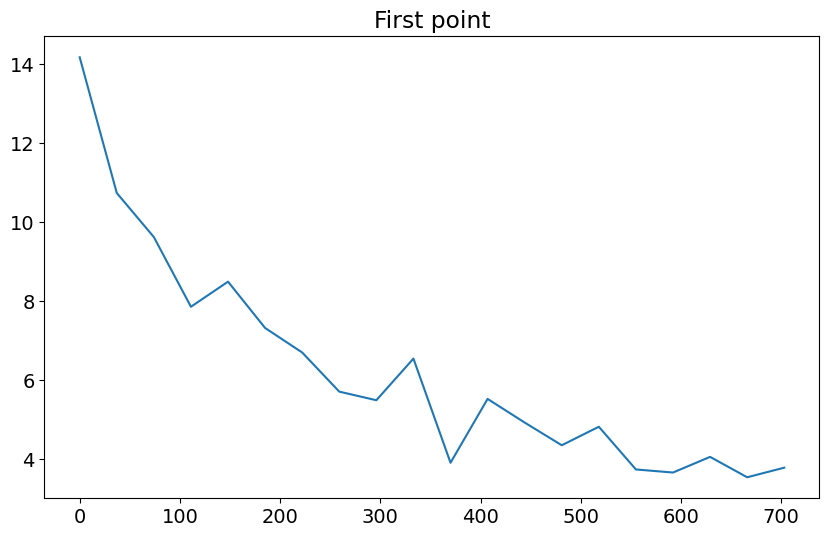

  0%|          | 0/5000 [00:00<?, ?it/s]

t1_i error:fit ratio= 0.16041467561738174
t1_q error:fit ratio= 0.3370454501717072
t1_i is better, saving T1_i to results cfg file
Saving C:\_Data\LLqub2\T1_short_2024-05-15-07-05-25\00007_t1_qubit3.h5
Fit T1 avgi [us]: 233.44255586860734
Fit T1 avgq [us]: 317.0822301599466


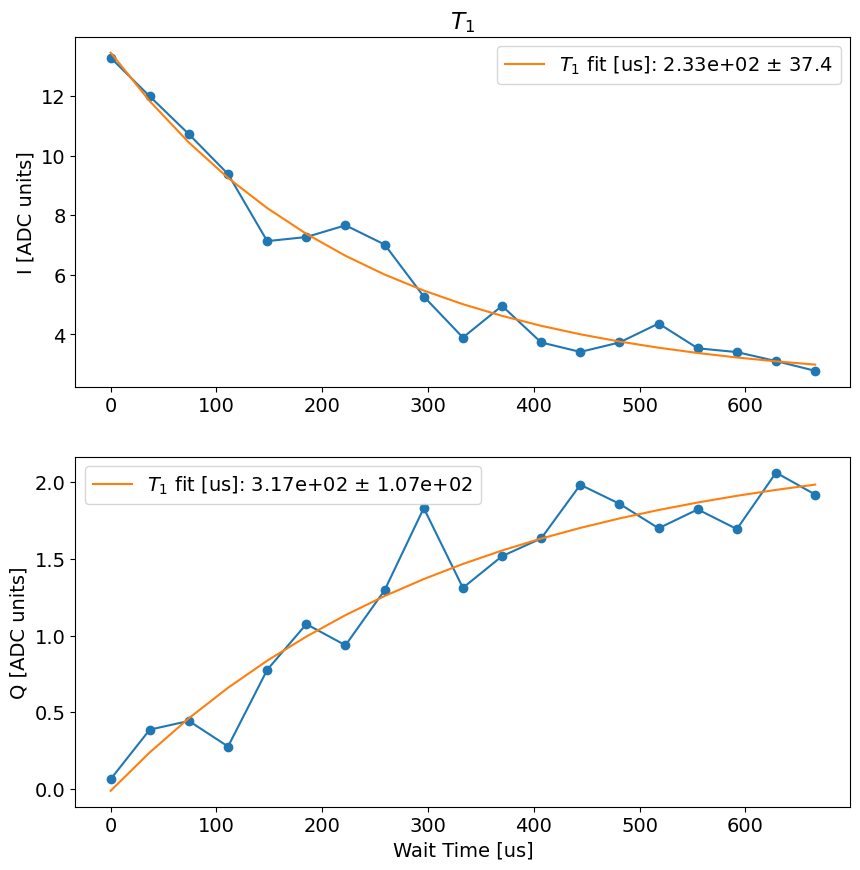

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
now = datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M-%S")
pth='C:\\_Data\\LLqub2\\'
folder_name = f"T1_short_{current_time}"
os.mkdir(pth + folder_name)
expt_path = pth + folder_name + '\\'
t1_rng = [50,250]
t2_rng = [50,500]
import time
t2_1 = 200
new_t1 = 200

i=3
while True:
    shot = cfg.make_singleshot(soc, expt_path, cfg_path, i, go=True, im=im, reps=30000)
   
    config.update_readout(cfg_file, 'phase', float(shot.data['angle']), i)
    config.update_readout(cfg_file, 'threshold', float(shot.data['thresholds'][0]), i)
    
    amp_rabi = cfg.make_amprabi(soc, expt_path, cfg_path, i, go=True, im=im, npts=20, reps=200)       
    auto_cfg = config.update_qubit(cfg_file, ('pulses','pi_ge','gain'), int(amp_rabi.data['pi_length']), i) 
    
    npts = 30
    t2r=cfg.make_t2r(soc, expt_path, cfg_path, i, go=True, im=im, ramsey_freq=npts/t2_1/8, npts=npts, reps=250, step=t2_1/npts)    
    auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(t2r.data['new_freq']), i)
    t2_1 = in_rng(t2r.data['fit_avgi'][3], t2_rng)

    npts =50
    t1 = cfg.make_t1(soc, expt_path, cfg_path, i, go=True, im=im, npts=npts, reps=250, rounds=4, span=3*new_t1)
    new_t1 = int(in_rng(t1.data['fit_avgi'][3], t1_rng))
    npts=20
    t1 = cfg.make_t1_2d(soc, expt_path, cfg_path, i, go=True, im=im, npts=npts, reps=200, span=4*new_t1, sweep_pts=1000)



### Continuous short T1 scans

In [46]:
while True:   
    t1 = cfg.make_t1(soc, expt_path, cfg_path, i, npts=25, reps=250)
    t1.go(analyze=True, display=True, progress=True, save=True)

IndexError: list index out of range

  0%|          | 0/6250 [00:00<?, ?it/s]

t1_amps error:fit ratio= 0.15215043142553883
t1_i error:fit ratio= 0.11367741704057552
t1_q error:fit ratio= 19363052.08513078
t1_i is better, saving T1_i to results cfg file
Saving C:\_Data\Coherence\T1_cont_2024-07-11-20-27-55\00002_t1_qubit0.h5
Fit T1 amps [us]: 19.353312430409698
Fit T1 avgi [us]: 17.106369591383423
Fit T1 avgq [us]: 0.15112774587284764


c:\_Lib\python\slab_rfsoc_expts\experiments\fitting.py:64: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-x/decay)


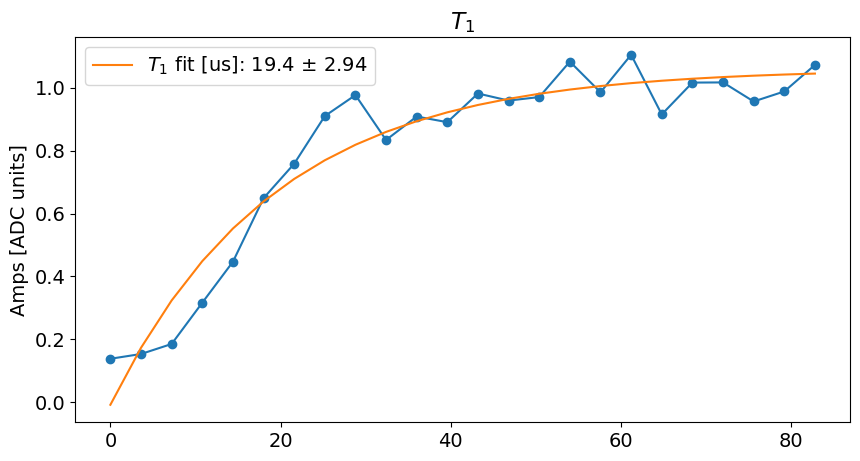

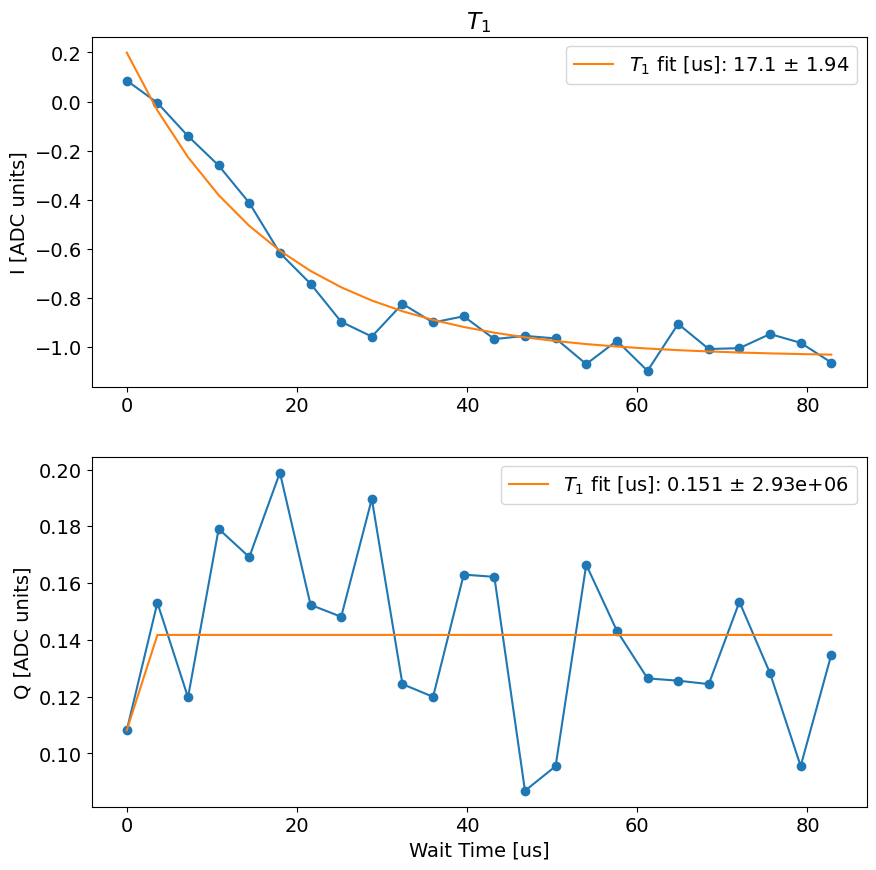

In [12]:
t1 = cfg.make_t1(soc, expt_path, cfg_path, i, im=im, npts=25, reps=250, span=90)
t1.go(analyze=True, display=True, progress=True, save=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00001_t1_2d_qubit3.h5


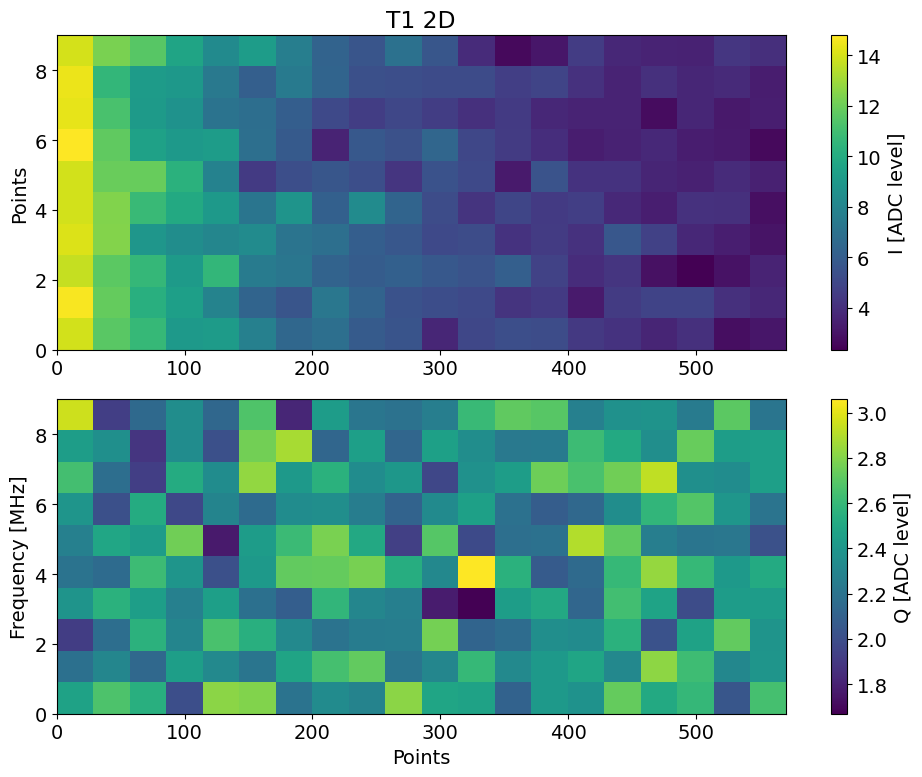

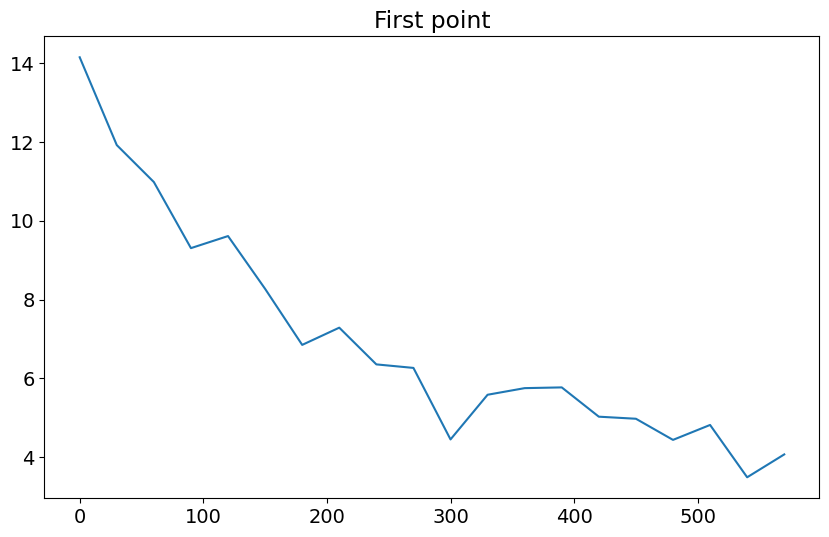

52.75209355354309


In [9]:
i=3
npts = 20
import time 

start=time.time()
t1 = cfg.make_t1_2d(soc, tuning_path, cfg_path, i, go=True, im=im, npts=npts, reps=200, span=3*200, sweep_pts=10)
end=time.time()
print(end-start)

### Set up 2D scans

In [12]:
qubit_i = 0
qubit_j = 4
# Function to run T1 continuous measurement
def run_continuous_t1(qubit_i, qubit_j, t1A, t1B):
    t1_cont = meas.T1_2qbContinuous(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_continuous_2qubit{qubit_i, qubit_j}",
        config_file=cfg_path,
    )
    npts = 1

    t1_cont.cfg.expt = dict(
        startA= t1A / npts,  # wait time [us]
        startB = t1B / npts,  # wait time [us]
        step=0,
        expts=npts,
        reps=5000,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubits=[qubit_i, qubit_j],
    )

    t1_cont.go(analyze=False, display=False, progress=True, save=True)

# Function to run T1 experiment for recalibration
def run_t1_recalibration(qubit_i, qubit_j):
    t1 = meas.T1_2qbExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_2qubit{qubit_i, qubit_j}",
        config_file=cfg_path,
    )

    span = 600
    npts = 20

    t1.cfg.expt = dict(
        startA=0,  # wait time [us]
        startB=0,  # wait time [us]
        step=span / npts,
        expts=npts,
        reps=200,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubits= [qubit_i, qubit_j],
        length_scan=span,  # length of the scan in us
        num_saved_points=1,  # number of points to save for the T1 continuous scan
    )

    t1.go(analyze=False, display=False, progress=True, save=True)
    return t1
    #t1.analyze(fit=True)
    #t1_fit_ia =t1.data['fit_avgia'][3]
    #t1_fit_ib = t1.data['fit_avgib'][3]
 


In [37]:
t1 = meas.T1_2qbExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_2qubit{qubit_i, qubit_j}",
    config_file=cfg_path,
)

span = 600
npts = 20

t1.cfg.expt = dict(
    startA=0,  # wait time [us]
    startB=0,  # wait time [us]
    step=int(span / npts),
    expts=npts,
    reps=200,  # number of times we repeat a time point
    rounds=1,  # number of start to finish sweeps to average over
    qubits= [qubit_i, qubit_j],
    length_scan=span,  # length of the scan in us
    num_saved_points=1,  # number of points to save for the T1 continuous scan
)


  0%|          | 0/200 [00:00<?, ?it/s]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [38]:

t1.go(analyze=False, display=False, progress=True, save=False)
t1.analyze(fit=True)
t1_fit_ia =t1.data['fit_avgia'][3]
t1_fit_ib = t1.data['fit_avgib'][3]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyError: 'xptsA'

In [34]:
t1_cont = meas.T1_2qbContinuous(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_continuous_2qubit{qubit_i, qubit_j}",
    config_file=cfg_path,
)

spanA = auto_cfg.device.qubit.T1[qubit_i]
spanB = auto_cfg.device.qubit.T1[qubit_j]
npts = 1

t1_cont.cfg.expt = dict(
    startA= spanA / npts,  # wait time [us]
    startB = spanB / npts,  # wait time [us]
    step=0,
    expts=npts,
    reps=5000,  # number of times we repeat a time point
    rounds=1,  # number of start to finish sweeps to average over
    qubits=[qubit_i, qubit_j],
)


  0%|          | 0/5000 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'encode'

In [ ]:
# Main script
qubit_i = 0
t1_raw_ia = np.array([])
t1_raw_ib =  np.array([])
start_time = timer()

while True:  # Run continuously
    # Run continuous T1 measurement
    t1_raw_ib, t1_raw_ia = np.append(run_continuous_t1(qubit_i, t1_raw_ia, t1_raw_ib), t1_raw_ia, t1_raw_ib)

    end_time = timer()
    if end_time - start_time >= 30:
        print( end_time - start_time, 'has passed. Running T1 recalibration.')
        # Run T1 experiment for recalibration
        t1 = run_t1_recalibration(qubit_i, qubit_j)
        start_time = timer()  # Reset the start time after recalibration


In [21]:
t1 = run_t1_recalibration(qubit_i, qubit_j)

  0%|          | 0/200 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 3, got 2)